# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and make changes there. __DO NOT__ request access to this tutorial.

# Install detectron2

In [1]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.8.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
import json

with open('/content/drive/MyDrive/Colab_Notebooks/dataset/od_custom/train/via_region_data.json', 'r') as f:
  train_data = json.load(f)

In [6]:
train_dataset_lst = [
  {
    'file_name': '/content/drive/MyDrive/Colab_Notebooks/dataset/od_custom/train/'+i['filename'],
    # 'height': 256, 'width': 256,
    'image_id': k,
    'annotations': [{
      'bbox_mode': detectron2.structures.BoxMode.XYWH_ABS,
      'bbox': [r['shape_attributes']['x'], r['shape_attributes']['y'], r['shape_attributes']['width'] - r['shape_attributes']['x'], r['shape_attributes']['height'] - r['shape_attributes']['y']],
      'category_id': 0
    } for r in i['regions']]
  }
  for k, i in train_data.items() if i['regions']
]

len(train_dataset_lst)

189

In [7]:
train_dataset_lst[0]

{'annotations': [{'bbox': [53, 43, 70, 98],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 0}],
 'file_name': '/content/drive/MyDrive/Colab_Notebooks/dataset/od_custom/train/101.jpg',
 'image_id': '101.jpg50451'}

In [8]:
with open('/content/drive/MyDrive/Colab_Notebooks/dataset/od_custom/val/via_region_data.json', 'r') as f:
  test_data = json.load(f)

In [9]:
test_dataset_lst = [
  {
    'file_name': '/content/drive/MyDrive/Colab_Notebooks/dataset/od_custom/val/'+i['filename'],
    # 'height': 256, 'width':256,
    'image_id': k,
    'annotations': [{
      'bbox_mode': detectron2.structures.BoxMode.XYWH_ABS,
      'bbox': [r['shape_attributes']['x'], r['shape_attributes']['y'], r['shape_attributes']['width'] - r['shape_attributes']['x'], r['shape_attributes']['height'] - r['shape_attributes']['y']],
      'category_id': 0
    } for r in i['regions']]
  }
  for k, i in test_data.items() if i['regions']
]

len(test_dataset_lst)

10

In [10]:
tr = random.sample(train_dataset_lst, len(train_dataset_lst))

DatasetCatalog.clear()
MetadataCatalog.clear()

DatasetCatalog.register("f_train", lambda: tr)
MetadataCatalog.get("f_train").set(thing_classes=['face'])

Metadata(name='f_train', thing_classes=['face'])

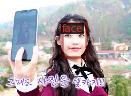

1 /content/drive/MyDrive/Colab_Notebooks/dataset/od_custom/train/222.jpg


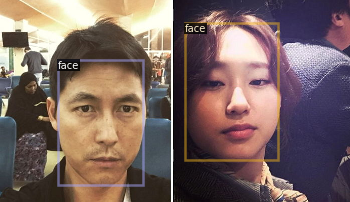

2 /content/drive/MyDrive/Colab_Notebooks/dataset/od_custom/train/144.jpg


In [11]:
for i, d in enumerate(tr[:2]):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("f_train"), scale=0.5)

    start_point =(d['annotations'][0]['bbox'][0], d['annotations'][0]['bbox'][1])
    end_point =(d['annotations'][0]['bbox'][2], d['annotations'][0]['bbox'][3])

    out = visualizer.draw_dataset_dict(d)

    cv2.rectangle(out.get_image()[:, :, ::-1], start_point, end_point, (200,0,0), 2)
    cv2_imshow(out.get_image()[:, :, ::-1])
    print(i+1, d["file_name"])

In [12]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("f_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 6
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 6
cfg.SOLVER.BASE_LR = 0.01  # pick a good LR
cfg.SOLVER.MAX_ITER = 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (face)

cfg.OUTPUT_DIR = "/content/drive/MyDrive/Colab_Notebooks/dataset/od_custom/models/faster_rcnn_r101_fpn"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/20 00:43:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
model_final_f6e8b1.pkl: 243MB [00:14, 16.6MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.b

[04/20 00:43:36 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[04/20 00:44:00 d2.utils.events]:  eta: 0:09:33  iter: 19  total_loss: 1.079  loss_cls: 0.5342  loss_box_reg: 0.5227  loss_rpn_cls: 0.04537  loss_rpn_loc: 0.01424  time: 1.1642  data_time: 0.0518  lr: 0.00019981  max_mem: 9918M
[04/20 00:44:24 d2.utils.events]:  eta: 0:09:15  iter: 39  total_loss: 0.9586  loss_cls: 0.301  loss_box_reg: 0.6087  loss_rpn_cls: 0.02121  loss_rpn_loc: 0.01289  time: 1.1849  data_time: 0.0295  lr: 0.00039961  max_mem: 9918M
[04/20 00:44:48 d2.utils.events]:  eta: 0:08:51  iter: 59  total_loss: 0.8261  loss_cls: 0.19  loss_box_reg: 0.6125  loss_rpn_cls: 0.007399  loss_rpn_loc: 0.0105  time: 1.1820  data_time: 0.0283  lr: 0.00059941  max_mem: 9918M
[04/20 00:45:12 d2.utils.events]:  eta: 0:08:30  iter: 79  total_loss: 0.7501  loss_cls: 0.1599  loss_box_reg: 0.5869  loss_rpn_cls: 0.005639  loss_rpn_loc: 0.01153  time: 1.1848  data_time: 0.0348  lr: 0.00079921  max_mem: 9918M
[04/20 00:45:35 d2.utils.events]:  eta: 0:08:03  iter: 99  total_loss: 0.5809  loss_cls

In [13]:
# cfg already contains everything we've set previously. Now we changed it a little bit for inference:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("f_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 20
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (face)

cfg.OUTPUT_DIR = "/content/drive/MyDrive/Colab_Notebooks/dataset/od_custom/models/faster_rcnn_r101_fpn"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
predictor = DefaultPredictor(cfg)

Instances(num_instances=1, image_height=251, image_width=201, fields=[pred_boxes: Boxes(tensor([[ 44.0618,  43.9066, 157.5525, 213.6480]], device='cuda:0')), scores: tensor([0.9970], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])


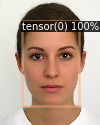

1 /content/drive/MyDrive/Colab_Notebooks/dataset/od_custom/val/1.jpg
Instances(num_instances=1, image_height=193, image_width=261, fields=[pred_boxes: Boxes(tensor([[ 90.1399,  16.0741, 196.6627, 159.2428]], device='cuda:0')), scores: tensor([0.9968], device='cuda:0'), pred_classes: tensor([0, 0], device='cuda:0')])


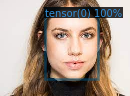

2 /content/drive/MyDrive/Colab_Notebooks/dataset/od_custom/val/10.jpg
Instances(num_instances=1, image_height=225, image_width=225, fields=[pred_boxes: Boxes(tensor([[ 72.5652,  46.8666, 157.6931, 171.0155]], device='cuda:0')), scores: tensor([0.9957], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])


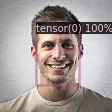

3 /content/drive/MyDrive/Colab_Notebooks/dataset/od_custom/val/2.jpg
Instances(num_instances=1, image_height=182, image_width=277, fields=[pred_boxes: Boxes(tensor([[116.8019,  33.6629, 198.8725, 151.4274]], device='cuda:0')), scores: tensor([0.9948], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])


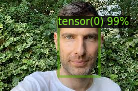

4 /content/drive/MyDrive/Colab_Notebooks/dataset/od_custom/val/3.jpg
Instances(num_instances=1, image_height=247, image_width=204, fields=[pred_boxes: Boxes(tensor([[ 54.6233,  42.1503, 138.4419, 159.3290]], device='cuda:0')), scores: tensor([0.9954], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])


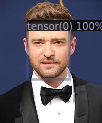

5 /content/drive/MyDrive/Colab_Notebooks/dataset/od_custom/val/4.jpg
Instances(num_instances=1, image_height=254, image_width=198, fields=[pred_boxes: Boxes(tensor([[ 55.9563,  36.7142, 151.0797, 181.8426]], device='cuda:0')), scores: tensor([0.9943], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])


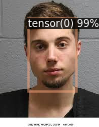

6 /content/drive/MyDrive/Colab_Notebooks/dataset/od_custom/val/5.jpg
Instances(num_instances=1, image_height=225, image_width=225, fields=[pred_boxes: Boxes(tensor([[ 59.1182,  32.9414, 168.8134, 192.4930]], device='cuda:0')), scores: tensor([0.9981], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])


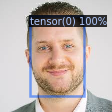

7 /content/drive/MyDrive/Colab_Notebooks/dataset/od_custom/val/6.jpg
Instances(num_instances=1, image_height=282, image_width=178, fields=[pred_boxes: Boxes(tensor([[ 38.8355,  56.8576, 149.0488, 232.0953]], device='cuda:0')), scores: tensor([0.9918], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0], device='cuda:0')])


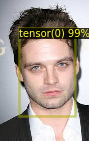

8 /content/drive/MyDrive/Colab_Notebooks/dataset/od_custom/val/7.jpg
Instances(num_instances=1, image_height=160, image_width=315, fields=[pred_boxes: Boxes(tensor([[162.9981,  10.6995, 231.2749, 103.6612]], device='cuda:0')), scores: tensor([0.9958], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])


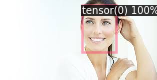

9 /content/drive/MyDrive/Colab_Notebooks/dataset/od_custom/val/8.jpg
Instances(num_instances=1, image_height=244, image_width=206, fields=[pred_boxes: Boxes(tensor([[ 73.7461,  50.8083, 145.9721, 164.2648]], device='cuda:0')), scores: tensor([0.9947], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])


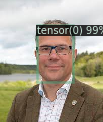

10 /content/drive/MyDrive/Colab_Notebooks/dataset/od_custom/val/9.jpg


In [14]:
te = [d for d in test_dataset_lst]

pred = []
real = []

#for i, d in random.sample(list(enumerate(te)), 10):
for i, d in enumerate(te[::1]):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    cut = outputs["instances"].scores > 0.8
    outputs["instances"]._fields['pred_boxes'] = outputs["instances"]._fields['pred_boxes'][cut]
    outputs["instances"].scores = outputs["instances"].scores[cut]
    print(outputs["instances"])
    outputs['instances'].pred_classes = outputs['instances'].pred_classes[cut]
    # print(outputs["instances"])
    v = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("face_train"), scale=0.5)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])
    print(i+1, d["file_name"])

    pred.append(len(d['annotations']))
    real.append(np.array(outputs["instances"].to("cpu").scores > 0.8).sum())

Instances(num_instances=6, image_height=182, image_width=277, fields=[pred_boxes: Boxes(tensor([[124.5381,  19.2271, 160.5395,  61.4231],
        [ 31.0049,  35.8576,  67.0417,  87.7268],
        [219.7741,  56.9261, 261.9268, 106.7714],
        [177.1739,  32.0172, 209.6546,  72.3134],
        [ 60.8252, 107.8693, 102.5421, 164.0456],
        [ 90.4026,  37.8109, 119.1368,  82.4712]], device='cuda:0')), scores: tensor([0.9983, 0.9982, 0.9979, 0.9977, 0.9977, 0.9949], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 0, 0], device='cuda:0')])


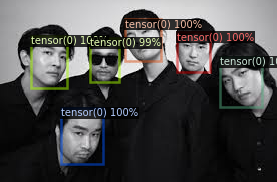

In [15]:
# Test with another data

img = cv2.imread("/content/drive/MyDrive/Colab_Notebooks/dataset/od_custom/images.jfif")
outputs = predictor(img)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
cut = outputs["instances"].scores > 0.8
outputs["instances"]._fields['pred_boxes'] = outputs["instances"]._fields['pred_boxes'][cut]
outputs["instances"].scores = outputs["instances"].scores[cut]
print(outputs["instances"])
outputs['instances'].pred_classes = outputs['instances'].pred_classes[cut]
# print(outputs["instances"])
v = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("face_train"), scale=1)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])